In [21]:
from IPython.display import clear_output

Uncomment and run the cell below if you are in a Google Colab environment. It will:

1. Mount google drive. You will be asked to authenticate and give permissions.
2. Change directory to google drive.
3. Make a directory "hamilton-tutorials"
4. Change directory to it.
5. Clone this repository to your google drive
6. Move your current directory to the example
7. Install requirements.
8. This means that any modifications will be saved, and you won't lose them if you close your browser.

In [22]:
## 1. Mount google drive
# from google.colab import drive
# drive.mount('/content/drive')
## 2. Change directory to google drive.
# %cd /content/drive/MyDrive
## 3. Make a directory "hamilton-tutorials"
# !mkdir hamilton-tutorials
## 4. Change directory to it.
# %cd hamilton-tutorials
## 5. Clone this repository to your google drive
# !git clone https://github.com/DAGWorks-Inc/hamilton-tutorials/
## 6. Move your current directory to the example
# %cd hamilton-tutorials/2023-10-09/pdf_summarizer
## 7. Install requirements.
# %pip install -r requirements.txt
# clear_output()  # optionally clear outputs
## To check your current working directory you can type `!pwd` in a cell and run it.

In [18]:
import os
import numpy as np
import pandas as pd
from hamilton import driver, base
from dagworks import adapters
from hamilton.function_modifiers import source
from hamilton.io.materialization import to
from IPython.display import display

# Use autoreload to automatically reload our function modules
%load_ext autoreload
%autoreload 1

# DAGWORKS_API_KEY = os.environ["DAGWORKS_STAGING_API_KEY"]
DAGWORKS_API_KEY = os.environ["DW_API_KEY"]
DAGWORKS_PROJECT_ID = 66 # 4
DAGWORKS_PROJECT_EMAIL = "stefan@dagworks.io"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
# set your openai API key
import openai
# openai.api_key = "YOUR_KEY_HERE"
openai.api_key = os.environ["OPENAI_API_KEY"]

In [20]:
%%writefile summarization.py

import io
import concurrent
from typing import Generator

from openai import OpenAI

client = OpenAI()
import tiktoken
from PyPDF2 import PdfReader
from tenacity import retry, stop_after_attempt, wait_random_exponential
from tqdm import tqdm

from hamilton.function_modifiers import config


def summarize_chunk_of_text_prompt(content_type: str = "an academic paper") -> str:
    """Base prompt for summarizing chunks of text."""
    return f"Summarize this text from {content_type}. Extract any key points with reasoning.\n\nContent:"


def summarize_text_from_summaries_prompt(content_type: str = "an academic paper") -> str:
    """Prompt for summarizing a paper from a list of summaries."""
    return f"""Write a summary collated from this collection of key points extracted from {content_type}.
    The summary should highlight the core argument, conclusions and evidence, and answer the user's query.
    User query: {{query}}
    The summary should be structured in bulleted lists following the headings Core Argument, Evidence, and Conclusions.
    Key points:\n{{results}}\nSummary:\n"""


@config.when(file_type="pdf")
def raw_text(pdf_source: io.BufferedReader) -> str:
    """Takes a filepath to a PDF and returns a string of the PDF's contents
    :param pdf_source: Series of filepaths to PDFs
    :return: Series of strings of the PDFs' contents
    """
    reader = PdfReader(pdf_source)
    _pdf_text = ""
    page_number = 0
    for page in reader.pages:
        page_number += 1
        _pdf_text += page.extract_text() + f"\nPage Number: {page_number}"
    return _pdf_text


def _create_chunks(text: str, n: int, tokenizer: tiktoken.Encoding) -> Generator[str, None, None]:
    """Helper function. Returns successive n-sized chunks from provided text.
    Split a text into smaller chunks of size n, preferably ending at the end of a sentence
    :param text:
    :param n:
    :param tokenizer:
    :return:
    """
    tokens = tokenizer.encode(text)
    i = 0
    while i < len(tokens):
        # Find the nearest end of sentence within a range of 0.5 * n and 1.5 * n tokens
        j = min(i + int(1.5 * n), len(tokens))
        while j > i + int(0.5 * n):
            # Decode the tokens and check for full stop or newline
            chunk = tokenizer.decode(tokens[i:j])
            if chunk.endswith(".") or chunk.endswith("\n"):
                break
            j -= 1
        # If no end of sentence found, use n tokens as the chunk size
        if j == i + int(0.5 * n):
            j = min(i + n, len(tokens))
        yield tokens[i:j]
        i = j


def chunked_text(
    raw_text: str, max_token_length: int = 1500, tokenizer_encoding: str = "cl100k_base"
) -> list[str]:
    """Chunks the pdf text into smaller chunks of size max_token_length.
    :param pdf_text: the Series of individual pdf texts to chunk.
    :param max_token_length: the maximum length of tokens in each chunk.
    :param tokenizer_encoding: the encoding to use for the tokenizer.
    :return: Series of chunked pdf text. Each element is a list of chunks.
    """
    tokenizer = tiktoken.get_encoding(tokenizer_encoding)
    _encoded_chunks = _create_chunks(raw_text, max_token_length, tokenizer)
    _decoded_chunks = [tokenizer.decode(chunk) for chunk in _encoded_chunks]
    return _decoded_chunks


@retry(wait=wait_random_exponential(min=1, max=40), stop=stop_after_attempt(3))
def _summarize_chunk(content: str, template_prompt: str, openai_gpt_model: str) -> str:
    """This function applies a prompt to some input content. In this case it returns a summarized chunk of text.
    :param content: the content to summarize.
    :param template_prompt: the prompt template to use to put the content into.
    :param openai_gpt_model: the openai gpt model to use.
    :return: the response from the openai API.
    """
    prompt = template_prompt + content
    response = client.chat.completions.create(model=openai_gpt_model, messages=[{"role": "user", "content": prompt}], temperature=0)
    return response.choices[0].message.content


def summarized_chunks(
    chunked_text: list[str], summarize_chunk_of_text_prompt: str, openai_gpt_model: str
) -> str:
    """Summarizes a series of chunks of text.
    Note: this takes the first result from the top_n_related_articles series and summarizes it. This is because
    the top_n_related_articles series is sorted by relatedness, so the first result is the most related.
    :param top_n_related_articles: series with each entry being a list of chunks of text for an article.
    :param summarize_chunk_of_text_prompt:  the prompt to use to summarize each chunk of text.
    :param openai_gpt_model: the openai gpt model to use.
    :return: a single string of each chunk of text summarized, concatenated together.
    """
    _summarized_text = ""
    with concurrent.futures.ThreadPoolExecutor(max_workers=len(chunked_text)) as executor:
        futures = [
            executor.submit(
                _summarize_chunk, chunk, summarize_chunk_of_text_prompt, openai_gpt_model
            )
            for chunk in chunked_text
        ]
        with tqdm(total=len(chunked_text)) as pbar:
            for _ in concurrent.futures.as_completed(futures):
                pbar.update(1)
        for future in futures:
            data = future.result()
            _summarized_text += data
    return _summarized_text


def prompt_and_text_content(
    summarize_text_from_summaries_prompt: str, user_query: str, summarized_chunks: str
) -> str:
    """Creates the prompt for summarizing the text from the summarized chunks of the pdf.
    :param summarize_text_from_summaries_prompt: the template to use to summarize the chunks.
    :param user_query: the original user query.
    :param summarized_chunks: a long string of chunked summaries of a file.
    :return: the prompt to use to summarize the chunks.
    """
    return summarize_text_from_summaries_prompt.format(query=user_query, results=summarized_chunks)


def summarized_text(
    prompt_and_text_content: str,
    openai_gpt_model: str,
) -> str:
    """Summarizes the text from the summarized chunks of the pdf.
    :param prompt_and_text_content: the prompt and content to send over.
    :param openai_gpt_model: which openai gpt model to use.
    :return: the string response from the openai API.
    """
    response = client.chat.completions.create(model=openai_gpt_model,
    messages=[
        {
            "role": "user",
            "content": prompt_and_text_content,
        }
    ],
    temperature=0)
    return response.choices[0].message.content


Overwriting summarization.py


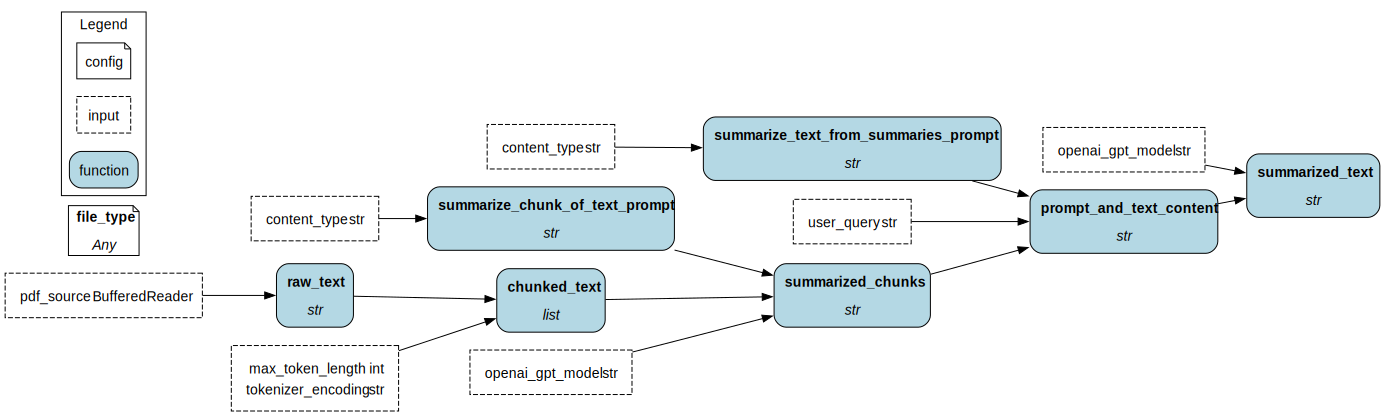

In [21]:
 # run as a script to test Hamilton's execution
import summarization

%aimport summarization


dw_tracker = adapters.DAGWorksTracker(
   project_id=DAGWORKS_PROJECT_ID,
   api_key=DAGWORKS_API_KEY,
   username=DAGWORKS_PROJECT_EMAIL,
   dag_name="notebook_dag",
   tags={"env": "local", "where": "notebook"}
)

dr = (
    driver.Builder()
    .with_config({"file_type": "pdf"})
    .with_modules(summarization)
    .with_adapters(dw_tracker)
    .build()
)

dr.display_all_functions()

In [22]:
# pull in a pdf
import requests

def download_file(url, filename):
  response = requests.get(url, stream=True)
  if response.status_code == 200:
    with open(filename, 'wb') as fd:
      for chunk in response.iter_content(chunk_size=1024):
        fd.write(chunk)

download_file("https://cdmsworkshop.github.io/2022/Proceedings/ShortPapers/Paper6_StefanKrawczyk.pdf", "hamilton_paper.pdf")

In [23]:
# inputs for the DAG
openai_gpt_model = "gpt-3.5-turbo-0613"
content_type = "Scientific article"
user_query = "Can you ELI5 the paper?"

In [24]:

with open("hamilton_paper.pdf", "rb") as f:
    result = dr.execute(["summarized_text"], inputs={
        "pdf_source": f,
        "openai_gpt_model": openai_gpt_model,
        "content_type": content_type,
        "user_query": user_query,
    })
print(result["summarized_text"])


Capturing execution run. Results can be found at https://app.dagworks.io/dashboard/project/66/runs/29313

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.29s/it]

Captured execution run. Results can be found at https://app.dagworks.io/dashboard/project/66/runs/29313



Core Argument:
- The Hamilton framework is a high-level modeling approach for dataflows that simplifies the user experience for data scientists and provides a unified interface for describing end-to-end dataflows.
- Traditional ETL approaches at Stitch Fix had problems such as poor documentation, low unit test coverage, limited code reuse, and difficulty in changing underlying infrastructure, which led to the development of the Hamilton framework.

Evidence:
- The Hamilton framework has been used to scale modeling dataflows at Stitch Fix to support over 4000 data transformations without impacting team and user productivity.
- The Hamilton programming paradigm encourages the use of vector computation, improves code readability and documentation, and allows for tight encapsulation of transform logic and unit testing.
- Hamilton provides decorators to encapsulate operational concerns and reduce repetitive function logic.
- The function DAG is the framework's representation of the nodes th

# Overrides
You can short-circuit computation by passing in an override. E.g. you store parts of the previous run, or you're iterating on something and want to change an implementation, etc.

In [30]:
with open("hamilton_paper.pdf", "rb") as f:
    result = dr.execute(
            ["summarized_text"],
            inputs=dict(
                pdf_source=f,
                openai_gpt_model=openai_gpt_model,
                content_type=content_type,
                user_query=user_query,
            ),
        overrides={"raw_text": "this is not a paper. Return a response of 'hi'."}
    )
print(result["summarized_text"])


Capturing execution run. All runs for project can be found at https://app.dagworks.io/dashboard/project/66/runs
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.13s/it]

Captured execution run. Results can be found at https://app.dagworks.io/dashboard/project/66/runs/1159



I'm sorry, but without a scientific article or text to summarize, I am unable to provide a summary. If you have any specific questions or need assistance with a different topic, please let me know and I'll be happy to help.


# Let's get intermediate outputs for monitoring/logging

In [31]:
with open("hamilton_paper.pdf", "rb") as f:
    result = dr.execute(
        ["summarize_text_from_summaries_prompt", "summarize_chunk_of_text_prompt"],
        inputs=dict(
            pdf_source=f,
            openai_gpt_model=openai_gpt_model,
            content_type=content_type,
            user_query=user_query,
        ))
import pprint
pprint.pprint(result)


Capturing execution run. All runs for project can be found at https://app.dagworks.io/dashboard/project/66/runs

Captured execution run. Results can be found at https://app.dagworks.io/dashboard/project/66/runs/1160



{'summarize_chunk_of_text_prompt': 'Summarize this text from Scientific '
                                   'article. Extract any key points with '
                                   'reasoning.\n'
                                   '\n'
                                   'Content:',
 'summarize_text_from_summaries_prompt': 'Write a summary collated from this '
                                         'collection of key points extracted '
                                         'from Scientific article.\n'
                                         '    The summary should highlight the '
                                         'core argument, conclusions and '
                                         "evidence, and answer the user's "
                                         'query.\n'
                                         '    User query: {query}\n'
                                         '    The summary should be structured '
                                         'in bullete

# Config.when
Use this as a way to have different node & thus DAG structure implementations. E.g. dev vs prod.

In [32]:
%%writefile summarization.py
import concurrent
import tempfile
from typing import Generator, Union

import openai
import tiktoken
from PyPDF2 import PdfReader
from tenacity import retry, stop_after_attempt, wait_random_exponential
from tqdm import tqdm

from hamilton.function_modifiers import config


def summarize_chunk_of_text_prompt(content_type: str = "an academic paper") -> str:
    """Base prompt for summarizing chunks of text."""
    return f"Summarize this text from {content_type}. Extract any key points with reasoning.\n\nContent:"


def summarize_text_from_summaries_prompt(content_type: str = "an academic paper") -> str:
    """Prompt for summarizing a paper from a list of summaries."""
    return f"""Write a summary collated from this collection of key points extracted from {content_type}.
    The summary should highlight the core argument, conclusions and evidence, and answer the user's query.
    User query: {{query}}
    The summary should be structured in bulleted lists following the headings Core Argument, Evidence, and Conclusions.
    Key points:\n{{results}}\nSummary:\n"""


@config.when(env="prod")
def raw_text__prod(pdf_source: Union[str, bytes, tempfile.SpooledTemporaryFile]) -> str:
    """Takes a filepath to a PDF and returns a string of the PDF's contents
    :param pdf_source: the path, or the temporary file, to the PDF.
    :return: the text of the PDF.
    """
    reader = PdfReader(pdf_source)
    _pdf_text = ""
    page_number = 0
    for page in reader.pages:
        page_number += 1
        _pdf_text += page.extract_text() + f"\nPage Number: {page_number}"
    return _pdf_text

@config.when(env="dev")
def raw_text__dev() -> str:
    """Function for dev purposes.
    """
    return """
    Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua.
    Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat.
    Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur.
    Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.
    """


def _create_chunks(text: str, n: int, tokenizer: tiktoken.Encoding) -> Generator[str, None, None]:
    """Helper function. Returns successive n-sized chunks from provided text.
    Split a text into smaller chunks of size n, preferably ending at the end of a sentence
    :param text:
    :param n:
    :param tokenizer:
    :return:
    """
    tokens = tokenizer.encode(text)
    i = 0
    while i < len(tokens):
        # Find the nearest end of sentence within a range of 0.5 * n and 1.5 * n tokens
        j = min(i + int(1.5 * n), len(tokens))
        while j > i + int(0.5 * n):
            # Decode the tokens and check for full stop or newline
            chunk = tokenizer.decode(tokens[i:j])
            if chunk.endswith(".") or chunk.endswith("\n"):
                break
            j -= 1
        # If no end of sentence found, use n tokens as the chunk size
        if j == i + int(0.5 * n):
            j = min(i + n, len(tokens))
        yield tokens[i:j]
        i = j


def chunked_text(
    raw_text: str, tokenizer_encoding: str = "cl100k_base", max_token_length: int = 1500
) -> list[str]:
    """Chunks the pdf text into smaller chunks of size max_token_length.
    :param raw_text: the Series of individual pdf texts to chunk.
    :param max_token_length: the maximum length of tokens in each chunk.
    :param tokenizer_encoding: the encoding to use for the tokenizer.
    :return: Series of chunked pdf text. Each element is a list of chunks.
    """
    tokenizer = tiktoken.get_encoding(tokenizer_encoding)
    _encoded_chunks = _create_chunks(raw_text, max_token_length, tokenizer)
    _decoded_chunks = [tokenizer.decode(chunk) for chunk in _encoded_chunks]
    return _decoded_chunks


@retry(wait=wait_random_exponential(min=1, max=40), stop=stop_after_attempt(3))
def _summarize_chunk(content: str, template_prompt: str, openai_gpt_model: str) -> str:
    """This function applies a prompt to some input content. In this case it returns a summarized chunk of text.
    :param content: the content to summarize.
    :param template_prompt: the prompt template to use to put the content into.
    :param openai_gpt_model: the openai gpt model to use.
    :return: the response from the openai API.
    """
    prompt = template_prompt + content
    response = openai.ChatCompletion.create(
        model=openai_gpt_model, messages=[{"role": "user", "content": prompt}], temperature=0
    )
    return response["choices"][0]["message"]["content"]


def summarized_chunks(
    chunked_text: list[str], summarize_chunk_of_text_prompt: str, openai_gpt_model: str
) -> str:
    """Summarizes a series of chunks of text.
    Note: this takes the first result from the top_n_related_articles series and summarizes it. This is because
    the top_n_related_articles series is sorted by relatedness, so the first result is the most related.
    :param chunked_text: a list of chunks of text for an article.
    :param summarize_chunk_of_text_prompt:  the prompt to use to summarize each chunk of text.
    :param openai_gpt_model: the openai gpt model to use.
    :return: a single string of each chunk of text summarized, concatenated together.
    """
    _summarized_text = ""
    with concurrent.futures.ThreadPoolExecutor(max_workers=len(chunked_text)) as executor:
        futures = [
            executor.submit(
                _summarize_chunk, chunk, summarize_chunk_of_text_prompt, openai_gpt_model
            )
            for chunk in chunked_text
        ]
        with tqdm(total=len(chunked_text)) as pbar:
            for _ in concurrent.futures.as_completed(futures):
                pbar.update(1)
        for future in futures:
            data = future.result()
            _summarized_text += data
    return _summarized_text


def prompt_and_text_content(
    summarized_chunks: str,
    summarize_text_from_summaries_prompt: str,
    user_query: str,
) -> str:
    """Creates the prompt for summarizing the text from the summarized chunks of the pdf.
    :param summarized_chunks: a long string of chunked summaries of a file.
    :param summarize_text_from_summaries_prompt: the template to use to summarize the chunks.
    :param user_query: the original user query.
    :return: the prompt to use to summarize the chunks.
    """
    return summarize_text_from_summaries_prompt.format(query=user_query, results=summarized_chunks)


def summarized_text(
    prompt_and_text_content: str,
    openai_gpt_model: str,
) -> str:
    """Summarizes the text from the summarized chunks of the pdf.
    :param prompt_and_text_content: the prompt and content to send over.
    :param openai_gpt_model: which openai gpt model to use.
    :return: the string response from the openai API.
    """
    response = openai.ChatCompletion.create(
        model=openai_gpt_model,
        messages=[
            {
                "role": "user",
                "content": prompt_and_text_content,
            }
        ],
        temperature=0,
    )
    return response["choices"][0]["message"]["content"]


Overwriting summarization.py


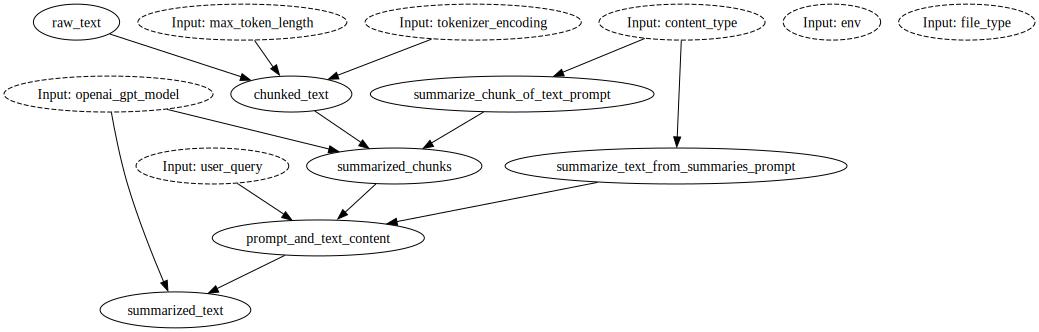

In [33]:
# Now we need to pass configuration in to create the right DAG shape
# dr = h_driver.Driver(
#     {"env": "dev"},  # DAG is now configuration based
#     summarization,
#     adapter=base.SimplePythonGraphAdapter(base.DictResult()),
# )

dw_tracker = adapters.DAGWorksTracker(
   project_id=DAGWORKS_PROJECT_ID,
   api_key=DAGWORKS_API_KEY,
   username=DAGWORKS_PROJECT_EMAIL,
   dag_name="notebook_dag",
   tags={"env": "local", "where": "notebook"}
)

dr = (
    driver.Builder()
    .with_config({"file_type": "pdf", "env": "dev"})  # DAG is now configuration based
    .with_modules(summarization)
    .with_adapters(dw_tracker)
    .build()
)

dr.display_all_functions()

# module swapping / combining
In addtion to @config.when, you can also swap things at a module level. A module houses some part of the DAG.
The contract to make things swappable just depends on the function name & output type. i.e. the names of the functions & types become the "interface".
E.g. to have different implementations of prompts, we just need to build modules that house a function with the right name.

In [34]:
%%writefile prompts1.py
# this is a version one of things
import concurrent
import tempfile
from typing import Generator, Union

import openai
import tiktoken
from PyPDF2 import PdfReader
from tenacity import retry, stop_after_attempt, wait_random_exponential
from tqdm import tqdm

from hamilton.function_modifiers import config


def summarize_chunk_of_text_prompt(content_type: str = "an academic paper") -> str:
    """Base prompt for summarizing chunks of text."""
    return f"Summarize this text from {content_type}. Extract any key points with reasoning.\n\nContent:"


def summarize_text_from_summaries_prompt(content_type: str = "an academic paper") -> str:
    """Prompt for summarizing a paper from a list of summaries."""
    return f"""Write a summary collated from this collection of key points extracted from {content_type}.
    The summary should highlight the core argument, conclusions and evidence, and answer the user's query.
    User query: {{query}}
    The summary should be structured in bulleted lists following the headings Core Argument, Evidence, and Conclusions.
    Key points:\n{{results}}\nSummary:\n"""

Overwriting prompts1.py


In [35]:
%%writefile prompts2.py
# this is a second version of things
import concurrent
import tempfile
from typing import Generator, Union

import openai
import tiktoken
from PyPDF2 import PdfReader
from tenacity import retry, stop_after_attempt, wait_random_exponential
from tqdm import tqdm

from hamilton.function_modifiers import config


def summarize_chunk_of_text_prompt(content_type: str = "an academic paper") -> str:
    """Base prompt for summarizing chunks of text."""
    return f"Summarize this text from {content_type}. Extract any key points with reasoning. Keep it concise. \n\nContent:"


def summarize_text_from_summaries_prompt(content_type: str = "an academic paper") -> str:
    """Prompt for summarizing a paper from a list of summaries."""
    return f"""Write a summary collated from this collection of key points extracted from {content_type}.
    The summary should highlight the core argument, evidence and conclusions, and answer the user's query.
    User query: {{query}}
    The summary should be structured in bulleted lists following the headings Core Argument, Evidence, and Conclusions.
    Key points:\n{{results}}\nSummary:\nAnswer to query:"""

Overwriting prompts2.py


In [36]:
%%writefile summarization_shortened.py
# modified module to accommodate
import concurrent
import tempfile
from typing import Generator, Union

import openai
import tiktoken
from PyPDF2 import PdfReader
from tenacity import retry, stop_after_attempt, wait_random_exponential
from tqdm import tqdm

from hamilton.function_modifiers import config


@config.when(env="prod")
def raw_text__prod(pdf_source: Union[str, bytes, tempfile.SpooledTemporaryFile]) -> str:
    """Takes a filepath to a PDF and returns a string of the PDF's contents
    :param pdf_source: the path, or the temporary file, to the PDF.
    :return: the text of the PDF.
    """
    reader = PdfReader(pdf_source)
    _pdf_text = ""
    page_number = 0
    for page in reader.pages:
        page_number += 1
        _pdf_text += page.extract_text() + f"\nPage Number: {page_number}"
    return _pdf_text

@config.when(env="dev")
def raw_text__dev() -> str:
    """Function for dev purposes.
    """
    return """
    Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. 
    Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. 
    Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. 
    Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.
    """


def _create_chunks(text: str, n: int, tokenizer: tiktoken.Encoding) -> Generator[str, None, None]:
    """Helper function. Returns successive n-sized chunks from provided text.
    Split a text into smaller chunks of size n, preferably ending at the end of a sentence
    :param text:
    :param n:
    :param tokenizer:
    :return:
    """
    tokens = tokenizer.encode(text)
    i = 0
    while i < len(tokens):
        # Find the nearest end of sentence within a range of 0.5 * n and 1.5 * n tokens
        j = min(i + int(1.5 * n), len(tokens))
        while j > i + int(0.5 * n):
            # Decode the tokens and check for full stop or newline
            chunk = tokenizer.decode(tokens[i:j])
            if chunk.endswith(".") or chunk.endswith("\n"):
                break
            j -= 1
        # If no end of sentence found, use n tokens as the chunk size
        if j == i + int(0.5 * n):
            j = min(i + n, len(tokens))
        yield tokens[i:j]
        i = j


def chunked_text(
    raw_text: str, tokenizer_encoding: str = "cl100k_base", max_token_length: int = 1500
) -> list[str]:
    """Chunks the pdf text into smaller chunks of size max_token_length.
    :param raw_text: the Series of individual pdf texts to chunk.
    :param max_token_length: the maximum length of tokens in each chunk.
    :param tokenizer_encoding: the encoding to use for the tokenizer.
    :return: Series of chunked pdf text. Each element is a list of chunks.
    """
    tokenizer = tiktoken.get_encoding(tokenizer_encoding)
    _encoded_chunks = _create_chunks(raw_text, max_token_length, tokenizer)
    _decoded_chunks = [tokenizer.decode(chunk) for chunk in _encoded_chunks]
    return _decoded_chunks


@retry(wait=wait_random_exponential(min=1, max=40), stop=stop_after_attempt(3))
def _summarize_chunk(content: str, template_prompt: str, openai_gpt_model: str) -> str:
    """This function applies a prompt to some input content. In this case it returns a summarized chunk of text.
    :param content: the content to summarize.
    :param template_prompt: the prompt template to use to put the content into.
    :param openai_gpt_model: the openai gpt model to use.
    :return: the response from the openai API.
    """
    prompt = template_prompt + content
    response = openai.ChatCompletion.create(
        model=openai_gpt_model, messages=[{"role": "user", "content": prompt}], temperature=0
    )
    return response["choices"][0]["message"]["content"]


def summarized_chunks(
    chunked_text: list[str], summarize_chunk_of_text_prompt: str, openai_gpt_model: str
) -> str:
    """Summarizes a series of chunks of text.
    Note: this takes the first result from the top_n_related_articles series and summarizes it. This is because
    the top_n_related_articles series is sorted by relatedness, so the first result is the most related.
    :param chunked_text: a list of chunks of text for an article.
    :param summarize_chunk_of_text_prompt:  the prompt to use to summarize each chunk of text.
    :param openai_gpt_model: the openai gpt model to use.
    :return: a single string of each chunk of text summarized, concatenated together.
    """
    _summarized_text = ""
    with concurrent.futures.ThreadPoolExecutor(max_workers=len(chunked_text)) as executor:
        futures = [
            executor.submit(
                _summarize_chunk, chunk, summarize_chunk_of_text_prompt, openai_gpt_model
            )
            for chunk in chunked_text
        ]
        with tqdm(total=len(chunked_text)) as pbar:
            for _ in concurrent.futures.as_completed(futures):
                pbar.update(1)
        for future in futures:
            data = future.result()
            _summarized_text += data
    return _summarized_text


def prompt_and_text_content(
    summarized_chunks: str,
    summarize_text_from_summaries_prompt: str,
    user_query: str,
) -> str:
    """Creates the prompt for summarizing the text from the summarized chunks of the pdf.
    :param summarized_chunks: a long string of chunked summaries of a file.
    :param summarize_text_from_summaries_prompt: the template to use to summarize the chunks.
    :param user_query: the original user query.
    :return: the prompt to use to summarize the chunks.
    """
    return summarize_text_from_summaries_prompt.format(query=user_query, results=summarized_chunks)


def summarized_text(
    prompt_and_text_content: object,
    openai_gpt_model: str,
) -> str:
    """Summarizes the text from the summarized chunks of the pdf.
    :param prompt_and_text_content: the prompt and content to send over.
    :param openai_gpt_model: which openai gpt model to use.
    :return: the string response from the openai API.
    """
    response = openai.ChatCompletion.create(
        model=openai_gpt_model,
        messages=[
            {
                "role": "user",
                "content": prompt_and_text_content,
            }
        ],
        temperature=0,
    )
    return response["choices"][0]["message"]["content"]


Overwriting summarization_shortened.py


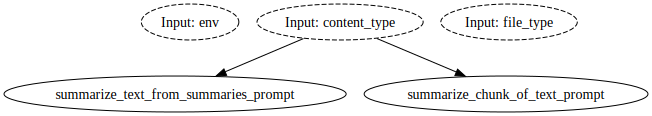

In [37]:
# You can then view the DAG by modules -- here just the prompt one.

%aimport prompts1
%aimport prompts2
%aimport summarization_shortened


dw_tracker = adapters.DAGWorksTracker(
   project_id=DAGWORKS_PROJECT_ID,
   api_key=DAGWORKS_API_KEY,
   username=DAGWORKS_PROJECT_EMAIL,
   dag_name="prompts2",
   tags={"env": "local", "where": "notebook"}
)

dr = (
    driver.Builder()
    .with_config({"file_type": "pdf", "env": "prod"})  # DAG is now configuration based
    .with_modules(prompts2)
    .with_adapters(dw_tracker)
    .build()
)

dr.display_all_functions()

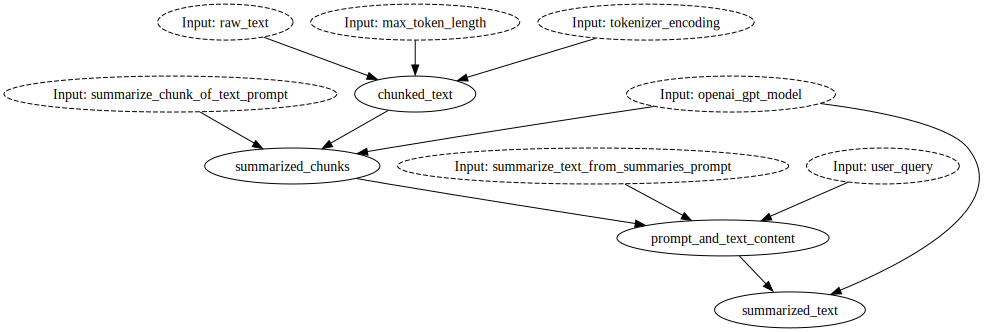

In [38]:
# here we're viewing the module without prompts. Note the prompts are now inputs -- so you could pass them in directly here.
dw_tracker = adapters.DAGWorksTracker(
   project_id=DAGWORKS_PROJECT_ID,
   api_key=DAGWORKS_API_KEY,
   username=DAGWORKS_PROJECT_EMAIL,
   dag_name="summarization_shortened",
   tags={"env": "local", "where": "notebook"}
)

dr = (
    driver.Builder()
    .with_config({})  # DAG is now configuration based
    .with_modules(summarization_shortened)
    .with_adapters(dw_tracker)
    .build()
)

dr.display_all_functions()

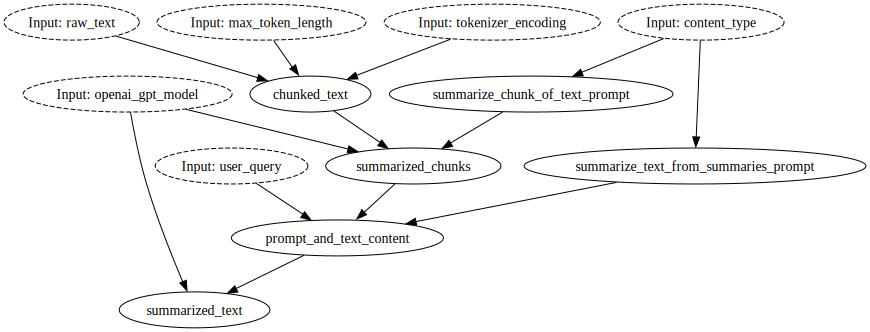

In [39]:
# as you see here, Hamilton stitched together the two modules and formed a larger DAG.
dw_tracker = adapters.DAGWorksTracker(
   project_id=DAGWORKS_PROJECT_ID,
   api_key=DAGWORKS_API_KEY,
   username=DAGWORKS_PROJECT_EMAIL,
   dag_name="prompt1_and_summarization_shortened",
   tags={"env": "local", "where": "notebook"}
)
dr = (
    driver.Builder()
    .with_config({})  # DAG is now configuration based
    .with_modules(prompts1, summarization_shortened)
    .with_adapters(dw_tracker)
    .build()
)
dr.display_all_functions()

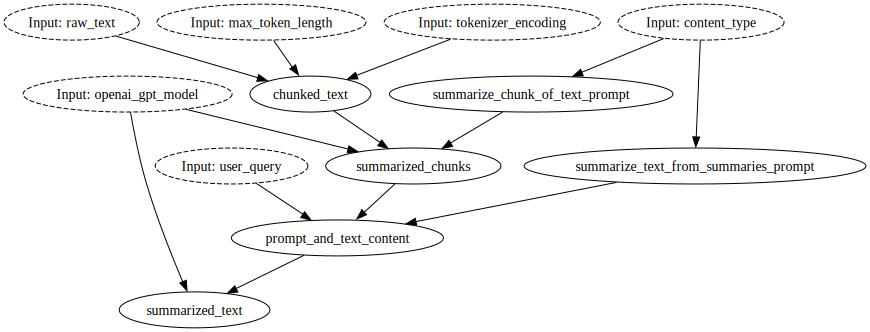

In [40]:
# same thing again, but showing prompts2 is swappable for prompts1.
dw_tracker = adapters.DAGWorksTracker(
   project_id=DAGWORKS_PROJECT_ID,
   api_key=DAGWORKS_API_KEY,
   username=DAGWORKS_PROJECT_EMAIL,
   dag_name="prompt2_and_summarization_shortened",
   tags={"env": "local", "where": "notebook"}
)
dr = (
    driver.Builder()
    .with_config({})  # DAG is now configuration based
    .with_modules(prompts2, summarization_shortened)
    .with_adapters(dw_tracker)
    .build()
)

dr.display_all_functions()